# Synthesizing robust adversarial examples
ICLR reproducibility challange: https://openreview.net/forum?id=BJDH5M-AW

**Implementing baseline algorithm**

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
import PIL
import numpy as np



In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess=tf.InteractiveSession()

In [4]:
image=tf.Variable(tf.zeros((299,299,3)))

In [5]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:]
        probs = tf.nn.softmax(logits)
    return logits, probs

logits, probs = inception(image, reuse=False)



In [6]:
import tempfile
from urllib.request import urlretrieve
import tarfile
import os

In [7]:
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)


In [8]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))


In [9]:
import json
import matplotlib.pyplot as plt

In [10]:
imagenet_json,_= urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels=json.load(f)

In [11]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()


In [13]:
img_path, _ = urlretrieve('https://raw.githubusercontent.com/prabhant/synthesizing-robust-adversarial-examples/master/elephant.jpg')
img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)


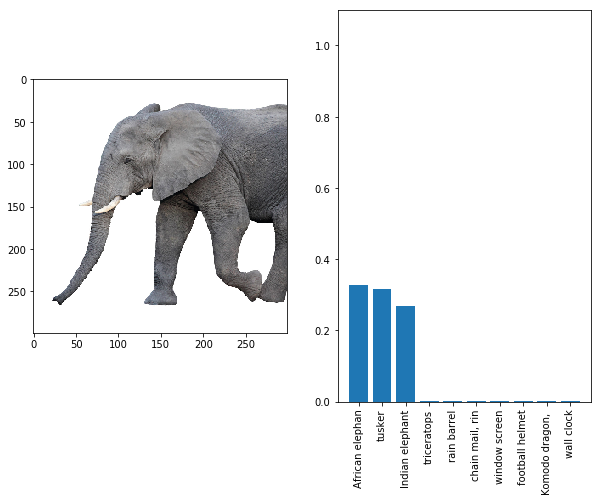

In [14]:
classify(img, correct_class=img_class)

In [15]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)



In [16]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])



In [17]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)


In [18]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example



step 10, loss=5.34693
step 20, loss=3.60821
step 30, loss=1.22267
step 40, loss=0.469383
step 50, loss=0.0385638
step 60, loss=0.0239993
step 70, loss=0.0176363
step 80, loss=0.0144434
step 90, loss=0.0125947
step 100, loss=0.0111795


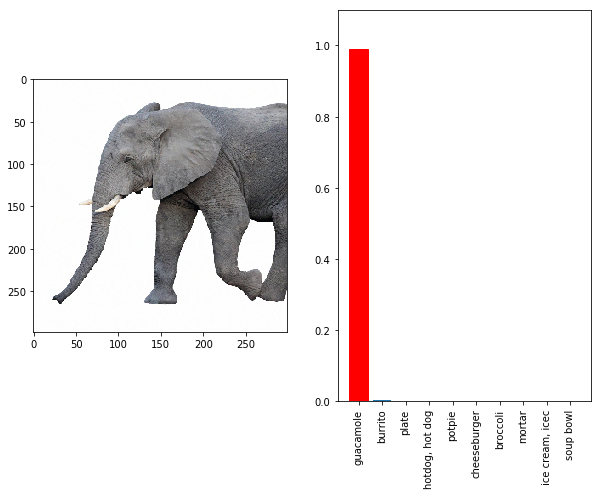

In [19]:
classify(adv, correct_class=img_class, target_class=demo_target)

In [20]:
demo_epsilon = 10.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example



step 10, loss=3.80572
step 20, loss=0.0895295
step 30, loss=0.0184445
step 40, loss=0.0120263
step 50, loss=0.0093026
step 60, loss=0.00770691
step 70, loss=0.00660605
step 80, loss=0.00581431
step 90, loss=0.00521727
step 100, loss=0.00473734


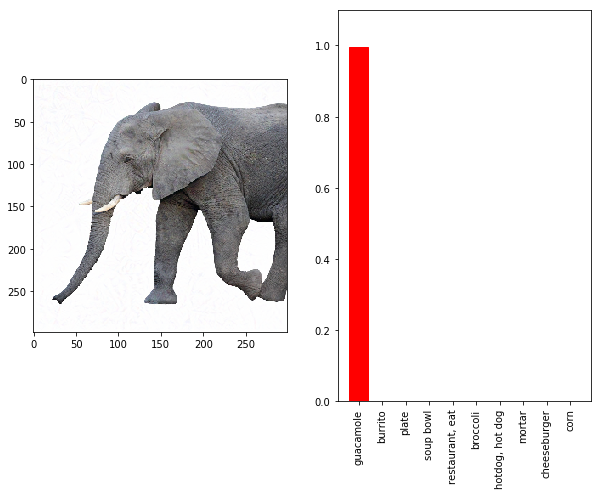

In [21]:
classify(adv, correct_class=img_class, target_class=demo_target)

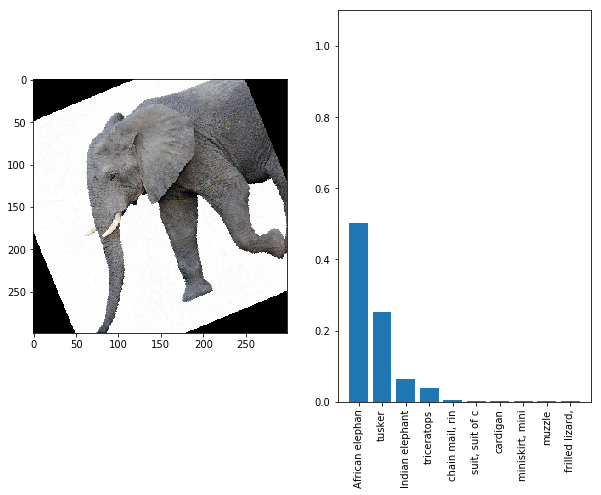

In [22]:
ex_angle = np.pi/8

angle = tf.placeholder(tf.float32, ())
rotated_image = tf.contrib.image.rotate(image, angle)
rotated_example = rotated_image.eval(feed_dict={image: adv, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

In [23]:
num_samples = 10
average_loss = 0
for i in range(num_samples):
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi/4, maxval=np.pi/4))
    rotated_logits, _ = inception(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples



In [ ]:
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(average_loss, var_list=[x_hat])



In [ ]:
demo_epsilon = 8.0/255.0 # still a pretty small perturbation
demo_lr = 2e-1
demo_steps = 100
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 50 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv_robust = x_hat.eval() # retrieve the adversarial example


step 50, loss=0.00363184


In [ ]:
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)


In [ ]:
thetas = np.linspace(-np.pi/4, np.pi/4, 301)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('rotation angle')
plt.ylabel('target class probability')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()



In [ ]:
demo_epsilon = 50.0/255.0 # still a pretty small perturbation
demo_lr = 2e-1
demo_steps = 100
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 50 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv_robust = x_hat.eval() # retrieve the adversarial example


In [ ]:
ex_angle=np.pi/2.5
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)


In [ ]:
ex_angle=np.pi/3
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)


We can see that this image is also out of the distribution but still there is a small percentage of guacmole prediction which wasn't there in earlier predictions.


In [ ]:
ex_angle=np.pi/1.5
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)


In [ ]:
ex_angle=np.pi
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)


In [ ]:
ex_angle=np.pi/1.77
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)


In this result too the rotation is way out of given distribution but hte guacmole in in top 7 predictions now

In [ ]:
num_samples = 10
average_loss = 0
for i in range(num_samples):
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi, maxval=np.pi))
    rotated_logits, _ = inception(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples

In [ ]:
demo_epsilon = 50.0/255.0 # still a pretty small perturbation
demo_lr = 1.5e-1
demo_steps = 200
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 50 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv_robust = x_hat.eval() # retrieve the adversarial example


In [ ]:
ex_angle=0
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)


## Check for transferability

Taking the adversarial example as an image to check for transferability for various scenarios

In [ ]:
import scipy.misc
scipy.misc.imsave('outfile4.jpg', rotated_example)

Testing on online classifiers give negative result as the output image was classified as cat most of the time though when the examples was in the distribution it was giving a reduced confidence (50%) rather than 90 percent for non perturbed examples

** Now let's test on pretrained classifiers**

In [ ]:
#code and results in "classify.ipynb" notebook

**Tested architectures:** Xception,VGG19,VGG16,Resnet,InceptionResnet,InceptionV3(keras)
<br>
<br>
**Transferability check:** After checking for transferability on various models it can be stated that the adversarial examples created by EOT are nontransferable for targeted attacks but highly transferable for non targeted attacks against similar architectures like Xception and resnet but not against VGG16 as well as VGG19.
<br>
<br>